In [1]:
!pip3 install pyro-ppl 

In [2]:
import os
import torch
import pyro
import logging
import matplotlib.pyplot as plt

In [3]:
%matplotlib inline
plt.style.use('default')
logging.basicConfig(format='%(message)s', level=logging.INFO)

## Generate artificial data set


In [4]:
import numpy as np
import matplotlib.pyplot as plt

N = 500  # number of data points
K = 2  # number of components
D = 2  # dimensionality of data

pi = np.array([0.4, 0.6])
mus = [[1, 1], [-1, -1]]
stds = [[0.1, 0.1], [0.1, 0.1]]
x_train = np.zeros((N, 2), dtype=np.float32)
for n in range(N):
  k = np.argmax(np.random.multinomial(1, pi))
  x_train[n, :] = np.random.multivariate_normal(mus[k], np.diag(stds[k]))

x_train = torch.tensor(x_train, dtype=torch.float)

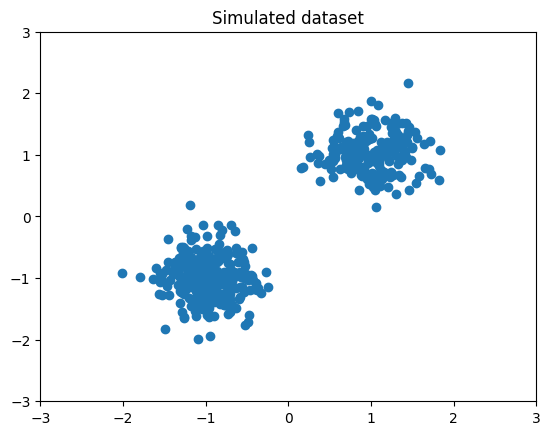

In [5]:
plt.scatter(x_train[:, 0], x_train[:, 1])
plt.axis([-3, 3, -3, 3])
plt.title("Simulated dataset")
plt.show()

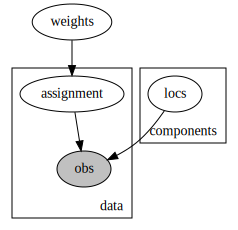

In [6]:
import pyro.distributions as dist

def model(data):
    weights = pyro.sample('weights', dist.Dirichlet(torch.ones(K)))

    with pyro.plate("components", K):
        locs = pyro.sample("locs", dist.MultivariateNormal(torch.zeros(2), 2 * torch.eye(2)))

    with pyro.plate("data", len(data)):
        assignment = pyro.sample("assignment", dist.Categorical(weights))
        pyro.sample("obs", dist.MultivariateNormal(locs[assignment], 0.1 * torch.eye(2)), obs=data)

pyro.render_model(model, model_args=(x_train,))

In [7]:
from pyro.infer import MCMC, NUTS
nuts_kernel = NUTS(model)
mcmc = MCMC(nuts_kernel, warmup_steps=500, num_samples=2000)
mcmc.run(x_train)
posterior_samples = mcmc.get_samples()

Sample: 100%|██████████| 2500/2500 [01:48, 23.00it/s, step size=6.45e-01, acc. prob=0.930]


In [10]:
print(posterior_samples['locs'].mean(dim=0))

tensor([[-0.9767, -0.9929],
        [ 1.0089,  1.0445]])
